# ML Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('mammographic_masses.data',names=['BI-RADS','Age','Shape','Margin','Density','Severity'])

In [3]:
dataset

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1
...,...,...,...,...,...,...
956,4,47,2,1,3,0
957,4,56,4,5,3,1
958,4,64,4,5,3,0
959,5,66,4,5,3,1


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [4]:
data = dataset.replace('?',np.NaN)

for each in data.columns:
    print(data[each].describe(),'\n')

count     959
unique      7
top         4
freq      547
Name: BI-RADS, dtype: object 

count     956
unique     73
top        59
freq       36
Name: Age, dtype: object 

count     930
unique      4
top         4
freq      400
Name: Shape, dtype: object 

count     913
unique      5
top         1
freq      357
Name: Margin, dtype: object 

count     885
unique      4
top         3
freq      798
Name: Density, dtype: object 

count    961.000000
mean       0.463059
std        0.498893
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Severity, dtype: float64 



Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [5]:
# data type has to be changed to float
data = data.astype('float64')

data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [6]:
# NaN values in each

data.isnull().sum()

BI-RADS      2
Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

#### Age and BI-RADS

In [7]:
data = data.drop((data[data['BI-RADS'].isnull()].index))

data = data.drop((data[data['Age'].isnull()].index))

#### Shape

In [8]:
# As seen here, not having a result for shape has a 62% chance for the person to be healthy
data[data['Shape'].isnull()]

,BI-RADS,Age,Shape,Margin,Density,Severity
6,4.0,70.0,NaN,NaN,3.0,0.0
9,5.0,60.0,NaN,5.0,1.0,1.0
48,2.0,42.0,NaN,NaN,4.0,0.0
54,4.0,53.0,NaN,5.0,3.0,1.0
74,5.0,70.0,NaN,4.0,NaN,1.0
83,4.0,57.0,NaN,4.0,1.0,0.0
128,4.0,52.0,NaN,4.0,NaN,0.0
157,4.0,51.0,NaN,NaN,3.0,0.0
163,4.0,53.0,NaN,4.0,3.0,0.0
236,3.0,60.0,NaN,3.0,1.0,0.0


In [9]:
data[data['Shape'].isnull()]['Severity'].value_counts()

0.0    19
1.0    11
Name: Severity, dtype: int64

In [10]:
# I will assign people without shape as 0

data['Shape'].replace(np.NaN,0,inplace=True)

#### Margin

In [11]:
# There is correlation all across the board when it comes to this feature

for each in data.columns:
    if each != 'Age':
        print(data[data['Margin'].isnull()][each].value_counts(),'\n')

4.0    27
5.0    12
3.0     5
2.0     2
6.0     1
Name: BI-RADS, dtype: int64 

1.0    16
2.0     9
3.0     9
0.0     9
4.0     4
Name: Shape, dtype: int64 

Series([], Name: Margin, dtype: int64) 

3.0    26
4.0     3
2.0     1
1.0     1
Name: Density, dtype: int64 

0.0    37
1.0    10
Name: Severity, dtype: int64 



In [12]:
data['Margin'].fillna(data['Margin'].median(), inplace=True)

#### Density

In [13]:
for each in data.columns:
    if each != 'Age':
        print(data[data['Density'].isnull()][each].value_counts(),'\n')

4.0    53
5.0    15
3.0     6
2.0     2
Name: BI-RADS, dtype: int64 

2.0    28
1.0    25
4.0    13
3.0     6
0.0     4
Name: Shape, dtype: int64 

1.0    36
3.0    20
4.0    15
5.0     4
2.0     1
Name: Margin, dtype: int64 

Series([], Name: Density, dtype: int64) 

0.0    54
1.0    22
Name: Severity, dtype: int64 



In [14]:
data['Density'].fillna(data['Density'].median(),inplace=True)

#### Overall look at everything now

In [15]:
data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,954.000000,954.000000,954.000000,954.00000,954.000000,954.000000
mean,4.345912,55.480084,2.628931,2.79979,2.919287,0.460168
std,1.787167,14.490874,1.312080,1.52996,0.361855,0.498672
min,0.000000,18.000000,0.000000,1.00000,1.000000,0.000000
25%,4.000000,45.000000,1.000000,1.00000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.00000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.00000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.00000,4.000000,1.000000


In [16]:
data.isnull().sum()

BI-RADS     0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64

Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [17]:
features = data.iloc[:,1:-1].values
target = data.iloc[:,-1].values
names = data.iloc[:,1:-1].columns.values

In [18]:
features.shape

(954, 4)

In [19]:
target.shape

(954,)

In [20]:
print(names)

['Age' 'Shape' 'Margin' 'Density']


Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [21]:
from sklearn.preprocessing import StandardScaler

features = StandardScaler().fit_transform(features)

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [22]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=False)

Now create a DecisionTreeClassifier and fit it to your training data.

In [42]:
criterion = ['gini','entropy']
k_list = []

depth = range(1,11)

for c in criterion:
    for k in depth:
        classifier = DTC(criterion=c, max_depth=k)
        classifier.fit(X_train, y_train)
        
        k_list.append(classifier.score(X_test,y_test))
        print(classifier.score(X_test,y_test), 'with k of',k,'and criterion',c)

0.7656903765690377 with k of 1 and criterion gini
0.803347280334728 with k of 2 and criterion gini
0.803347280334728 with k of 3 and criterion gini
0.8284518828451883 with k of 4 and criterion gini
0.8326359832635983 with k of 5 and criterion gini
0.8284518828451883 with k of 6 and criterion gini
0.8284518828451883 with k of 7 and criterion gini
0.8200836820083682 with k of 8 and criterion gini
0.8242677824267782 with k of 9 and criterion gini
0.8117154811715481 with k of 10 and criterion gini
0.7656903765690377 with k of 1 and criterion entropy
0.803347280334728 with k of 2 and criterion entropy
0.803347280334728 with k of 3 and criterion entropy
0.8284518828451883 with k of 4 and criterion entropy
0.8284518828451883 with k of 5 and criterion entropy
0.8242677824267782 with k of 6 and criterion entropy
0.8242677824267782 with k of 7 and criterion entropy
0.8117154811715481 with k of 8 and criterion entropy
0.8158995815899581 with k of 9 and criterion entropy
0.8158995815899581 with k 

In [26]:
from matplotlib import pyplot as plt

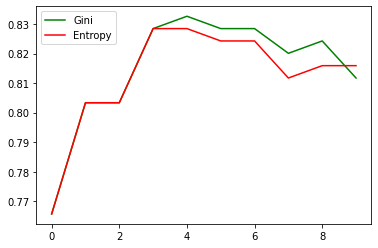

In [45]:
plt.plot(range(10),k_list[:10],c='green',label='Gini')
plt.plot(range(10),k_list[10:],c='red',label='Entropy')
plt.legend()

plt.show()

Display the resulting decision tree.

In [74]:
classifier = DTC(criterion='gini', max_depth=4)
classifier.fit(X_train, y_train)
# The ideal model

classifier.score(X_test, y_test)

0.8284518828451883

Measure the accuracy of the resulting decision tree model using your test data.

In [47]:
from sklearn import tree

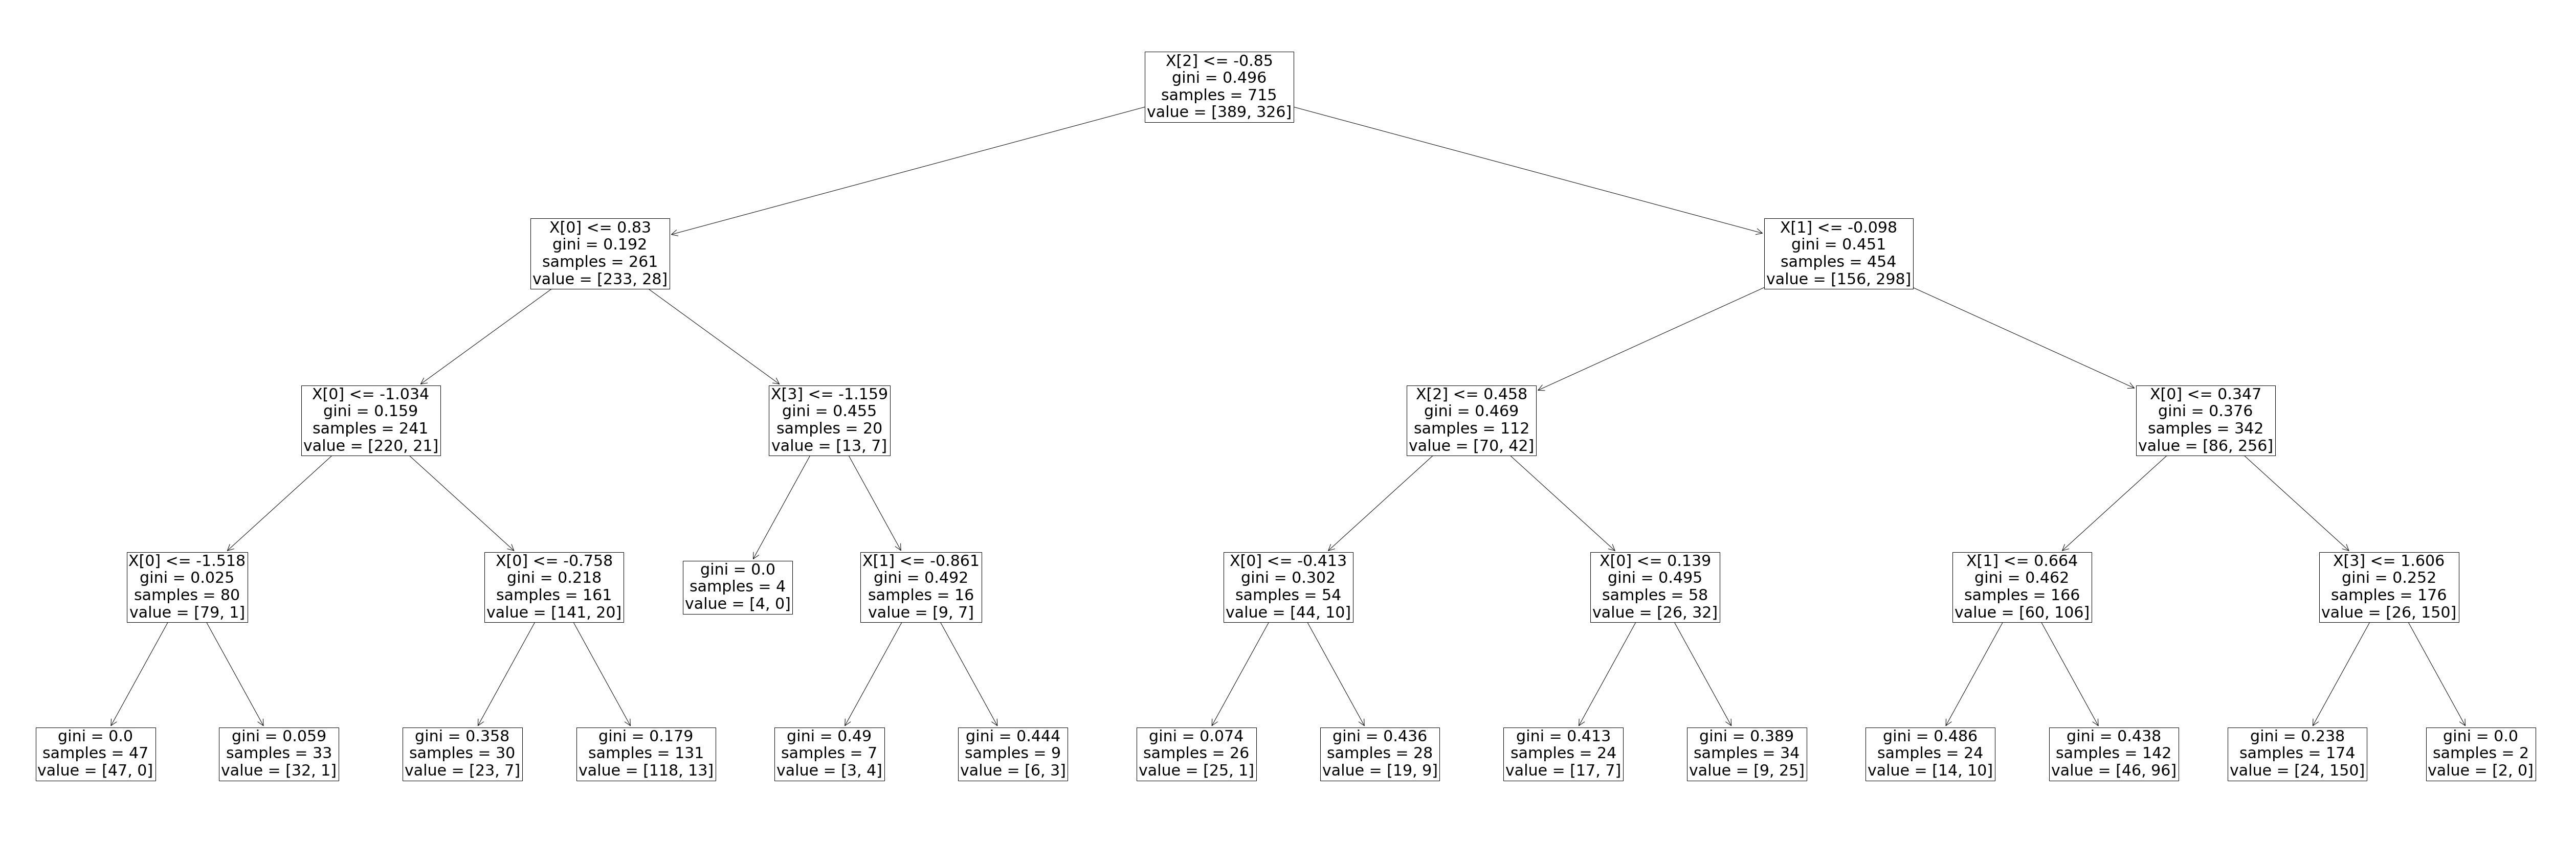

In [49]:
fig, ax = plt.subplots(figsize=(90,30))
tree.plot_tree(classifier, fontsize=30)

plt.show() # little bit cramped

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [59]:
from sklearn.model_selection import cross_val_score

cross_val_score(DTC(max_depth=10), X_train, y_train)

array([0.74125874, 0.77622378, 0.72027972, 0.78321678, 0.70629371])

Now try a RandomForestClassifier instead. Does it perform better?

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
criterion = ['gini','entropy']
k_list = []

depth = range(1,16)

for c in criterion:
    for k in depth:
        classifier = RandomForestClassifier(criterion=c, max_depth=k)
        classifier.fit(X_train, y_train)
        
        k_list.append(classifier.score(X_test,y_test))
        print(classifier.score(X_test,y_test), 'with k of',k,'and criterion',c)

0.803347280334728 with k of 1 and criterion gini
0.8242677824267782 with k of 2 and criterion gini
0.8284518828451883 with k of 3 and criterion gini
0.8326359832635983 with k of 4 and criterion gini
0.8284518828451883 with k of 5 and criterion gini
0.8326359832635983 with k of 6 and criterion gini
0.8284518828451883 with k of 7 and criterion gini
0.8158995815899581 with k of 8 and criterion gini
0.8158995815899581 with k of 9 and criterion gini
0.8117154811715481 with k of 10 and criterion gini
0.803347280334728 with k of 11 and criterion gini
0.799163179916318 with k of 12 and criterion gini
0.799163179916318 with k of 13 and criterion gini
0.803347280334728 with k of 14 and criterion gini
0.7782426778242678 with k of 15 and criterion gini
0.803347280334728 with k of 1 and criterion entropy
0.8158995815899581 with k of 2 and criterion entropy
0.8326359832635983 with k of 3 and criterion entropy
0.8284518828451883 with k of 4 and criterion entropy
0.8326359832635983 with k of 5 and cri

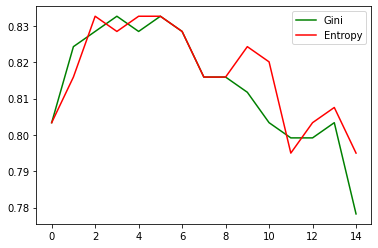

In [72]:
plt.plot(range(15),k_list[:15],c='green',label='Gini')
plt.plot(range(15),k_list[15:],c='red',label='Entropy')
plt.legend()

plt.show()
# Entropy, k=2

In [73]:
rfc = RandomForestClassifier(criterion='entropy',max_depth=2)
rfc.fit(X_train, y_train)

rfc.score(X_test, y_test)

0.8242677824267782

In [ ]:
# Conclusion: decision tree classifier is slightly better than random forest classifier, most liikely because of the low number of features

## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [75]:
from sklearn.svm import SVC

In [80]:
classifier_SVC = SVC(kernel='linear')
classifier_SVC.fit(X_train,y_train)

classifier_SVC.score(X_test, y_test)

0.8075313807531381

In [ ]:
# Slightly less than decision tree

## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [91]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [92]:
model = KNN().fit(X_train, y_train)
model.score(X_test, y_test)

0.8075313807531381

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

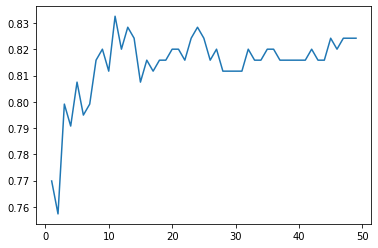

In [94]:
scores = []

for k in range(1,50):
  model = KNN(n_neighbors=k).fit(X_train, y_train)
  scores.append(model.score(X_test,y_test))

plt.plot(range(1,50), scores)

In [96]:
# k=10 is best
model = KNN(n_neighbors=10).fit(X_train, y_train)
model.score(X_test, y_test)

0.8117154811715481

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [98]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB as MNB

In [103]:
scaler = MinMaxScaler()

modell = MNB().fit(scaler.fit_transform(X_train),y_train)
modell.score(scaler.fit_transform(X_test),y_test)

0.7280334728033473

In [ ]:
# A terrible score, since not all of the features here have good correlation 

## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [108]:
kernels = ['rbf','sigmoid','poly']
degree = range(1,7)
c = [0.1,1,10,100]

scores = []

for k in kernels:
  for d in degree:
    for c_ in c:
      model = SVC(kernel=k,degree=d,C=c_)
      model.fit(X_train, y_train)

      scores.append(model.score(X_test, y_test))
      print(model.score(X_test, y_test), 'Kernel:',k,'Degree:',d,'Coefficient:',c_)

0.803347280334728 Kernel: rbf Degree: 1 Coefficient: 0.1
0.8158995815899581 Kernel: rbf Degree: 1 Coefficient: 1
0.8242677824267782 Kernel: rbf Degree: 1 Coefficient: 10
0.8200836820083682 Kernel: rbf Degree: 1 Coefficient: 100
0.803347280334728 Kernel: rbf Degree: 2 Coefficient: 0.1
0.8158995815899581 Kernel: rbf Degree: 2 Coefficient: 1
0.8242677824267782 Kernel: rbf Degree: 2 Coefficient: 10
0.8200836820083682 Kernel: rbf Degree: 2 Coefficient: 100
0.803347280334728 Kernel: rbf Degree: 3 Coefficient: 0.1
0.8158995815899581 Kernel: rbf Degree: 3 Coefficient: 1
0.8242677824267782 Kernel: rbf Degree: 3 Coefficient: 10
0.8200836820083682 Kernel: rbf Degree: 3 Coefficient: 100
0.803347280334728 Kernel: rbf Degree: 4 Coefficient: 0.1
0.8158995815899581 Kernel: rbf Degree: 4 Coefficient: 1
0.8242677824267782 Kernel: rbf Degree: 4 Coefficient: 10
0.8200836820083682 Kernel: rbf Degree: 4 Coefficient: 100
0.803347280334728 Kernel: rbf Degree: 5 Coefficient: 0.1
0.8158995815899581 Kernel: rbf 

In [110]:
# RBF with coefficient of 10 is the winner, with score of 0.8242677824267782

## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [111]:
from sklearn.linear_model import LogisticRegression

In [114]:
model_LR = LogisticRegression().fit(X_train, y_train)
model_LR.score(X_test, y_test)

0.803347280334728

## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [115]:
from sklearn.neural_network import MLPClassifier

In [116]:
model_MLP = MLPClassifier(max_iter=1000)

model_MLP.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [117]:
model_MLP.score(X_test, y_test)

0.8284518828451883

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!

In [ ]:
# Neural network and decision tree got the exact same score, which just happens to be the best one, score of ~83%